# How to create a gif showing how the brain substructures change over time?

In [1]:
from pathlib import Path

import pyvista as pv

import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing import PartiallyInitializedStep
from polpo.preprocessing.load.fsl import get_all_first_structs
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.registration import PvAlign

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading meshes

NB: we perform rigid alignment on the meshes wrt the first mesh.

In [3]:
structs = get_all_first_structs(include_brstem=False, order=True)

In [4]:
subject_id = "01"

mesh_loader = (
    MeshLoader(
        subject_subset=[subject_id],
        struct_subset=structs,
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey()
    + ppdict.NestedDictSwapper()
)

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: ppdict.DictMap(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[list(meshes.keys())[0]],
    max_iterations=500,
)


pipe = mesh_loader + ppdict.DictMap(prep_pipe)

# prefixed_struct, time
meshes = pipe()

## Create gif

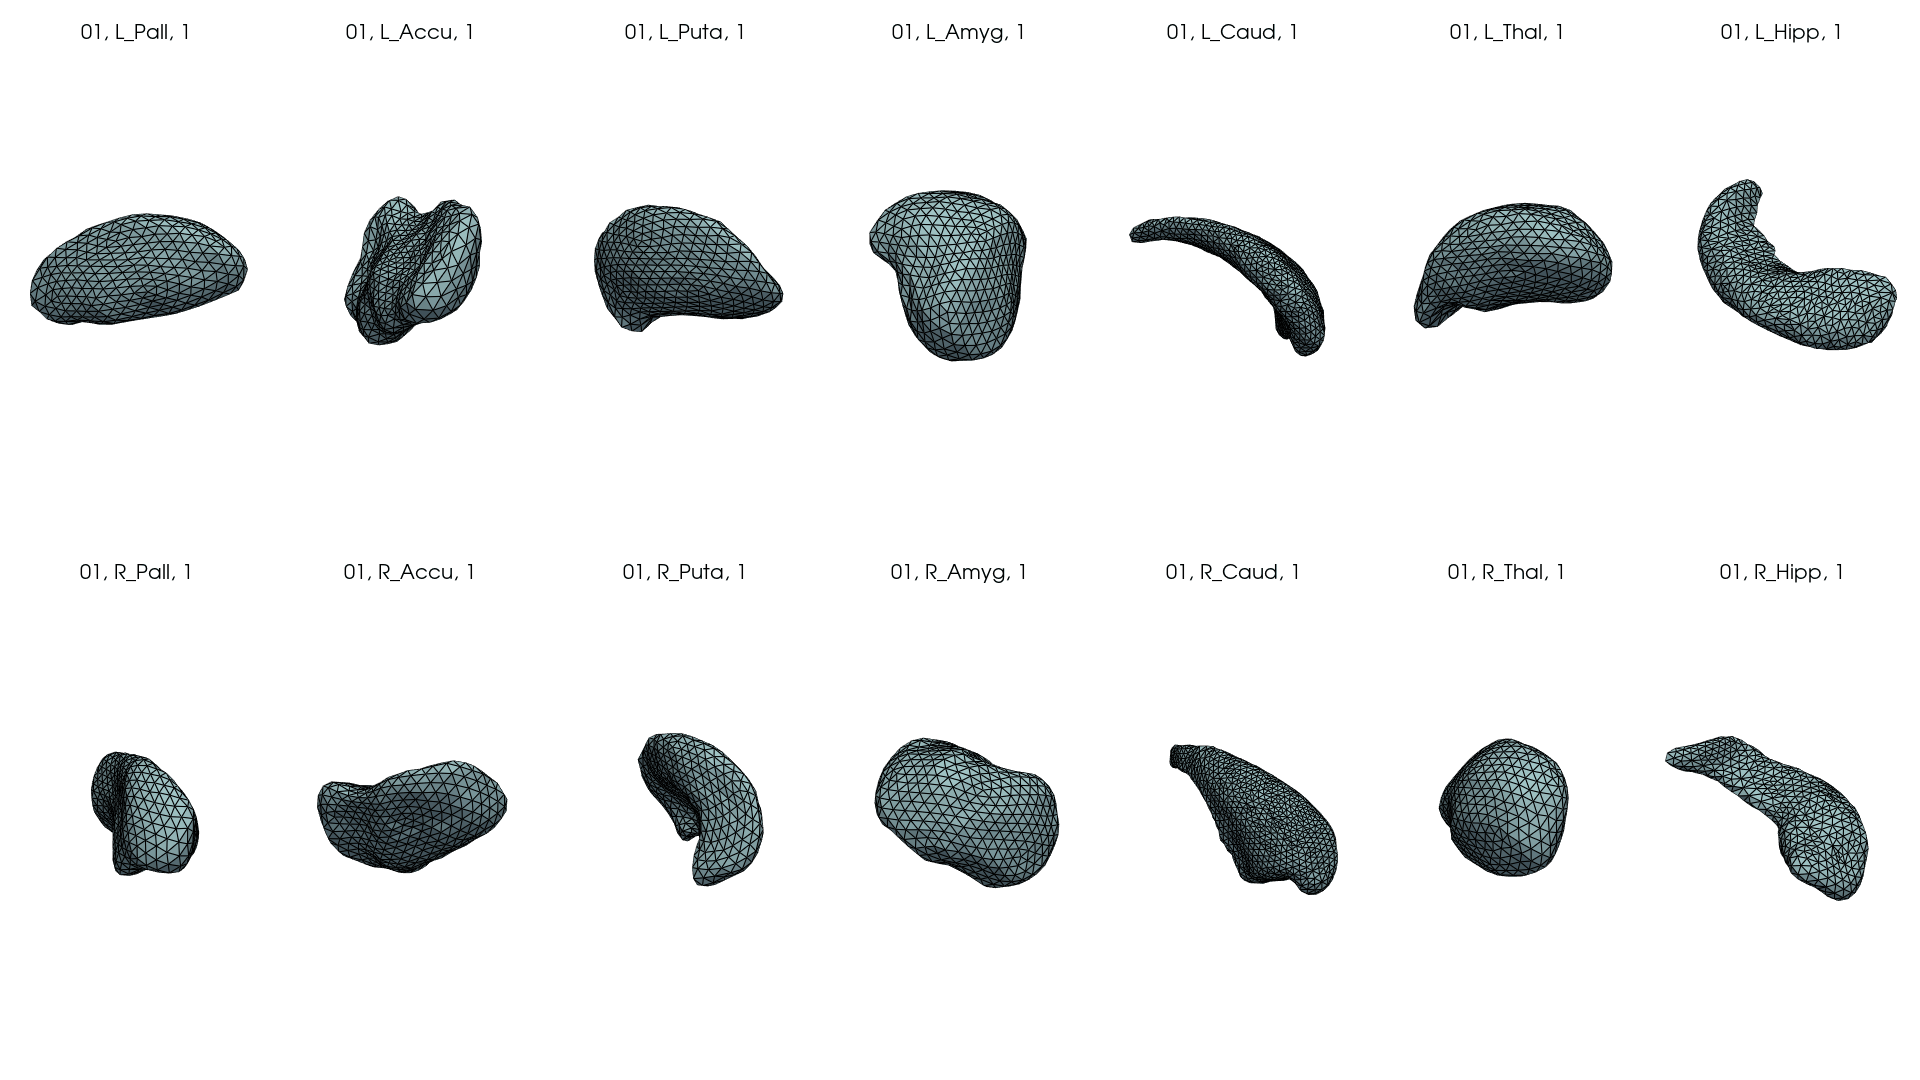

In [5]:
gif_dir = Path("_images")
gif_dir.mkdir(exist_ok=True)

gif_name = gif_dir / f"{subject_id}_all_structs.gif"


pl = RegisteredMeshesGifPlotter(
    shape=putils.plot_shape_from_n_plots(len(meshes), n_axis=2, axis=0),
    rowise=False,
    gif_name=gif_name.as_posix(),
    fps=5,
    border=False,
    off_screen=True,
    notebook=False,
    window_size=(1920, 1080),
    subtitle=(
        lambda session_id, struct_name: f"{subject_id}, {struct_name}, {session_id}"
    ),
)

pl.add_meshes(ppdict.NestedDictSwapper()(meshes))
pl.close()

pl.show()